In [ ]:
import torch

from torchvision import transforms, datasets
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

data_dir= 'leukemia_nuclei/training_data'
dataset= datasets.ImageFolder(data_dir)

Using device: mps


In [2]:
data_dir_0= 'leukemia_nuclei/training_data/fold_0'
dataset_0= datasets.ImageFolder(data_dir_0)
dataset_0.classes

['all', 'hem']

In [3]:
data_dir_1= 'leukemia_nuclei/training_data/fold_1'
dataset_1= datasets.ImageFolder(data_dir_1)
dataset_1.classes

['all', 'hem']

In [4]:
data_dir_2= 'leukemia_nuclei/training_data/fold_2'
dataset_2= datasets.ImageFolder(data_dir_2)
dataset_2.classes

['all', 'hem']

In [31]:
from pathlib import Path

def count_images_by_class(root):
    root = Path(root)
    out = {}
    for cls in sorted(p.name for p in root.iterdir() if p.is_dir()):
        cnt = sum(
            1 for p in (root / cls).rglob("*")
            if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
        )
        out[cls] = cnt
    return out

for name, d in {
    "fold_0": data_dir_0,
    "fold_1": data_dir_1,
    "fold_2": data_dir_2,
}.items():
    print(name, count_images_by_class(d))


fold_0 {'all': 2397, 'hem': 1130}
fold_1 {'all': 2418, 'hem': 1163}
fold_2 {'all': 2457, 'hem': 1096}


In [5]:
from torch.utils.data import ConcatDataset

In [6]:
dataset_join = ConcatDataset([dataset_0, dataset_1, dataset_2] )
dataset_join.classes= dataset_2.classes
len(dataset_join)

10661

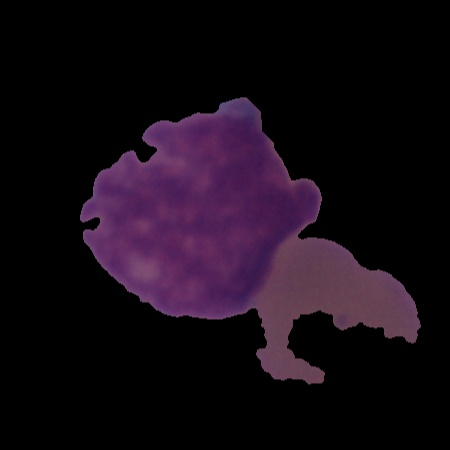

In [7]:
image, y = dataset_join[3]
image

In [8]:
from torch.utils.data import random_split
torch.manual_seed(42)

In [9]:
dataset_train,dataset_test= random_split(dataset_join, (0.8, 0.2))
len(dataset_test)

2132

In [10]:
from torchvision import transforms

tain_transform =transforms.Compose([transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
                                   ])

In [11]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
])

In [12]:
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
dataset_train = TransformDataset(dataset_train, transform = tain_transform)
dataset_test = TransformDataset(dataset_test, transform = test_transform)

In [13]:
from torch import nn
import torch.nn.functional as F
import numpy as np

In [14]:
from torchvision import models

resnet34 = models.resnet34(pretrained=True)
resnet34

/opt/anaconda3/envs/tf-notes/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/tf-notes/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/naraptis/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:10<00:00, 8.01MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
class MyModel(nn.Module):
     def __init__(self):
         super().__init__()
         resnet =models.resnet34(pretrained=True) 
         for parameter in resnet.parameters():
             parameter.requires_grad = False
         resnet.fc = nn.Identity()
         self.resnet = resnet
         self.linear = nn.Linear(512,2)
     def  forward(self,x):
        out = self.resnet(x)
        out = self.linear(out)
        return out

In [17]:
model=MyModel().to(device)
model

MyModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [18]:
from torch.utils.data import DataLoader

train_loader= DataLoader(dataset_train, batch_size =128,shuffle=True)
test_loader= DataLoader(dataset_test, batch_size =128,shuffle=True)

In [19]:
loss_fn = nn.CrossEntropyLoss()  


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [22]:
history= train(model, optimizer, loss_fn, train_loader, test_loader,
      metrics=None, metrics_name=None, 
      epochs=5, 
      device=device, 
      task='multiclass')

train() called: model=MyModel, opt=Adam(lr=0.001000), epochs=5, device=mps

Epoch    1   74sec	loss:      0.515	val_loss:      0.449	
Epoch    2   31sec	loss:      0.451	val_loss:      0.434	
Epoch    3   31sec	loss:      0.443	val_loss:      0.421	
Epoch    4   31sec	loss:      0.432	val_loss:      0.421	
Epoch    5   30sec	loss:      0.435	val_loss:      0.423	

Time total:     197.44 sec


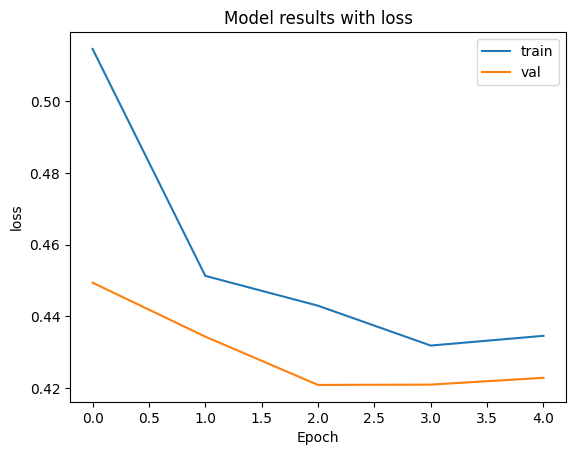

In [23]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

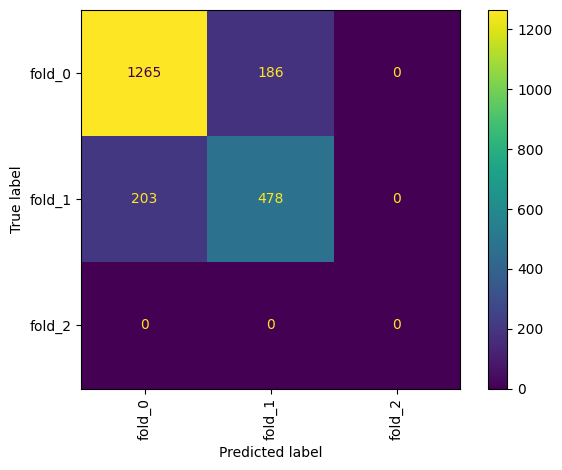

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

model = model.to(device)
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)

        logits = model(X)
        preds = logits.argmax(dim=-1).cpu().numpy()

        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

labels = list(range(len(dataset.classes)))  # [0,1,2] for 3 classes

ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    labels=labels,
    display_labels=dataset.classes,
    xticks_rotation=90
)
plt.tight_layout()
plt.show()
